In [ ]:
#@title Check GPU { vertical-output: true}

!nvidia-smi 

Wed Oct  6 21:14:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Connect to Drive { vertical-output: true, display-mode: "form" }

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Libraries :**

In [ ]:
#@title Import and Install Libraries { vertical-output: true, display-mode: "form" }
from IPython import display

!pip install keras-layer-normalization
display.clear_output()
print("keras-layer-normalization library is installed successfully")
!pip install -U kora
display.clear_output()
print("keras-layer-normalization library is installed successfully")
print("kora library is installed successfully")

print()
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import tensorflow as tf
import cv2
import os
import keras
import time 
import shutil
import csv
import imageio
import scipy.io

from sklearn.metrics import roc_auc_score
from kora.drive import upload_public
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model
from keras_layer_normalization import LayerNormalization
from matplotlib.animation import FuncAnimation, writers
import matplotlib.patches as mpatches
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
from google.colab.patches import cv2_imshow
from IPython.display import HTML
print("All librairies are imported successfully")

keras-layer-normalization library is installed successfully
kora library is installed successfully

All librairies are imported successfully


## **Defining Paths and Parameters :**

In [ ]:
#@title Defining  Paths and Parameters

class Path :
  plot = "/content/drive/Shareddrives/Others/Internship/Images/model.png"
  def __init__(self, choice, num) :
    name = choice
    if (choice == "ped1") :
      self.train = "/content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train"
      self.test = "/content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Test"
      self.fps = 13
    elif (choice == "ped2"):
      self.train = "/content/drive/Shareddrives/Others/Internship/Datasets/UCSDped2/Train"
      self.test = "/content/drive/Shareddrives/Others/Internship/Datasets/UCSDped2/Test"
      self.fps = 26
    elif choice == "avenue" :
      self.train = "/content/drive/Shareddrives/Others/Internship/Datasets/Avenue Dataset/training_videos"
      self.test = "/content/drive/Shareddrives/Others/Internship/Datasets/Avenue Dataset/testing_videos"
    elif choice == "shanghaitech" :
      name = name + str(num)
      self.train = "/content/drive/Shareddrives/Others/Internship/Datasets/Shanghaitech/Set{}/Train".format(num)
      self.test = "/content/drive/Shareddrives/Others/Internship/Datasets/Shanghaitech/Set{}/Test".format(num)
      self.fps = 25

    self.result = "/content/drive/Shareddrives/Others/Internship/Results/"+name
    self.model = "/content/drive/Shareddrives/Others/Internship/Models/"+name+"/model.hdf5"
    self.history = "/content/drive/Shareddrives/Others/Internship/History/"+name+"/model_history_log.csv"
    self.checkpoint = "/content/drive/Shareddrives/Others/Internship/Checkpoint/"+name+"/checkpoint-{epoch:02d}-{loss:.4f}.hdf5"
    self.video = "/content/drive/Shareddrives/Others/Internship/Videos/"+name
    self.loss = "/content/drive/Shareddrives/Others/Internship/Images/"+name+"/Loss/{}-epochs.png"
    self.regularity = "/content/drive/Shareddrives/Others/Internship/Images/"+name+"/Regularity/Test{}.png"

print("Paths and Parameters are defined successfully")

Paths and Parameters are defined successfully


## **Choice of Dataset :**

In [ ]:
#@title Choice of Dataset { display-mode: "form" }
choice =  "ped2" #@param ["ped1", "ped2", "avenue", "shanghaitech"]
#@markdown If your choice is shanghaitech datasets, choose the number of dataset :
num =  3#@param {type : "integer"}
paths = Path(choice, num)

In [ ]:
#@title Preprocessing step for ShanghaiTech Dataset
i = 0
for f in sorted(listdir(paths.train)):
  directory_path = join(paths.train, f)
  if os.path.isfile(directory_path) :
    i = i+1
    new = "{0:02}.avi".format(i)
    new_path = join(paths.train, new)
    os.rename(directory_path, new_path) 

i = 0
for f in sorted(listdir(paths.test)):
  i = i+1
  directory_path = join(paths.test, f)
  new = "Test{0:03}".format(i)
  new_path = join(paths.test, new)
  os.rename(directory_path, new_path) 
  for ff in (listdir(new_path)):
    im_path = join(new_path, ff)
    if im_path[-3:] == "jpg":
      im = Image.open(im_path)
      im.save(im_path[:-3]+'tiff') 
      os.remove(im_path)
    if im_path[-6:] == "..tiff":
      os.rename(im_path, im_path[:-6]+".tiff") 
print("Dataset is been processed successfully")

## **Create and Delete Folders :**

In [ ]:
#@title Define a function that create and delete folders

def create_delete_folder (path, option):
  if option == "Create" :
    if not os.path.exists(path):
      os.makedirs(path)
  elif option == "Delete" :
    shutil.rmtree(path)

In [ ]:
#@title Create or Delete Folder

path = "/content/drive/Shareddrives/Others/Internship/History/shanghaitech3" #@param {type:"string"}
option = 'Create' #@param ["Create", "Delete"]

create_delete_folder (path, option)

## **Extract frames from video :**

In [ ]:
#@title Define a function that transform a video into frames
def video_to_frames (IMAGE_PATH, VIDEO_PATH, fps) :
  num_files = len([name for name in os.listdir('.') if os.path.isfile(name)])
  if os.path.exists(IMAGE_PATH):
    create_delete_folder (IMAGE_PATH, "Delete")
  create_delete_folder (IMAGE_PATH, "Create")

  EXTENSION = ".tif"
  cap = cv2.VideoCapture(VIDEO_PATH)
  orig_fps = round(cap.get(cv2.CAP_PROP_FPS))
  # exit()
  hop = round(orig_fps / fps)
  curr_frame = 0
  while(True):
    ret, frame = cap.read()
    if not ret: 
      break
    if curr_frame % hop == 0:
      name = IMAGE_PATH + '{0:03}'.format(curr_frame//hop) + EXTENSION
      cv2.imwrite(name, frame)

      img = Image.open(name)
      img.getdata()
      r, g, b = img.split()
      ra = np.array(r)
      ga = np.array(g)
      ba = np.array(b)
      gray = (0.299*ra + 0.587*ga + 0.114*ba)
      #plt.imshow(gray, cmap="gray")
      cv2.imwrite(name, gray)
      cv2.imwrite(name[:-3]+"jpg", gray)
      im = Image.open(name[:-3]+"jpg")
      im.save(name, 'TIFF')
      os.remove(name[:-3]+"jpg")
    curr_frame += 1
  print("Video"+VIDEO_PATH[-6:-4]+" : {} frames are extracted from this video".format(curr_frame-1))
  cap.release()

In [ ]:
#@title If your choice is Avenue or ShanghaiTech Datasets :{ display-mode: "form" }

fps =  13#@param {type:"integer"}

if choice == "avenue" :
  num_files = len([name for name in os.listdir(paths.train) if os.path.isfile(os.path.join(paths.train, name))])
  print("Number of videos for this dataset : {}".format(num_files))
  for i in range(num_files):
    VIDEO_PATH = paths.train+'/{0:02}.avi'.format(i+1)
    IMAGE_PATH =paths.train+'/Train{0:03}/'.format(i+1)
    video_to_frames (IMAGE_PATH, VIDEO_PATH, fps)
  num_files = len([name for name in os.listdir(paths.test) if os.path.isfile(os.path.join(paths.test, name))])
  print("Number of videos for this dataset : {}".format(num_files))
  for i in range(num_files):
    VIDEO_PATH = paths.test+'/{0:02}.avi'.format(i+1)
    IMAGE_PATH =paths.test+'/Test{0:03}/'.format(i+1)
    video_to_frames (IMAGE_PATH, VIDEO_PATH, fps)
elif choice == "shanghaitech" :
  num_files = len([name for name in os.listdir(paths.train) if os.path.isfile(os.path.join(paths.train, name))])
  print("Number of videos for this dataset : {}".format(num_files))
  for i in range(num_files):
    VIDEO_PATH = paths.train+'/{0:02}.avi'.format(i+1)
    IMAGE_PATH =paths.train+'/Train{0:03}/'.format(i+1)
    video_to_frames (IMAGE_PATH, VIDEO_PATH, fps)


Number of videos for this dataset : 6
Video01 : 324 frames are extracted from this video
Video02 : 399 frames are extracted from this video
Video03 : 349 frames are extracted from this video
Video04 : 524 frames are extracted from this video
Video05 : 424 frames are extracted from this video
Video06 : 274 frames are extracted from this video


## **Import Data :**

In [ ]:
#@title Import Train Dataset

def get_clips_by_stride(frames_list, sequence_size):
  clips = []
  sz = len(frames_list)
  clip = np.zeros(shape=(sequence_size, 224, 224, 1))
  cnt = 0
  for i in range(0, sz):
    clip[cnt, :, :, 0] = frames_list[i]
    cnt = cnt + 1
    if cnt == sequence_size:
      clips.append(np.copy(clip))
      cnt = 0
  return clips

def import_data (path):
  clips = []
  i = 0
  for f in sorted(listdir(path)):
    i=i+1
    directory_path = join(path, f)
    if isdir(directory_path) and i<55:
      print("# Importing "+directory_path)
      all_frames = []
      for c in sorted(listdir(directory_path)):
        img_path = join(directory_path, c)
        if str(img_path)[-3:] == "tif":
          img = Image.open(img_path).resize((224, 224))
          img = np.array(img, dtype=np.float32) / 256.0
          all_frames.append(img)
      clips.extend(get_clips_by_stride(frames_list=all_frames, sequence_size=8))
  return clips
  
print("Reading Images from folders :")
training_set = np.array(import_data (paths.train))
print("Trainning Set is imported successfully \n")
print("Trainning Set Shape = ",training_set.shape)

Reading Images from folders :
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train001
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train002
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train003
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train004
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train005
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train006
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train007
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train008
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train009
# Importing /content/drive/Shareddrives/Others/Internship/Datasets/UCSDped1/Train/Train010
# Importing /content/drive/Shareddrives/Others/Internship/Da

## **Create Model :**

In [ ]:
#@title Create Model

def create_model():
  model = Sequential(name="ConvLSTM-AE")
  model.add(TimeDistributed(Conv2D(128, (27, 27), strides=4, padding="same"), batch_input_shape=(None, 8, 224, 224, 1)))
  model.add(LayerNormalization())
  model.add(TimeDistributed(Conv2D(64, (13, 13), strides=2, padding="same")))
  model.add(LayerNormalization())
  # # # # #
  model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
  model.add(LayerNormalization())
  model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
  model.add(LayerNormalization())
  model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
  model.add(LayerNormalization())
  # # # # #
  model.add(TimeDistributed(Conv2DTranspose(64, (13, 13), strides=2, padding="same")))
  model.add(LayerNormalization())
  model.add(TimeDistributed(Conv2DTranspose(128, (27, 27), strides=4, padding="same")))
  model.add(LayerNormalization())
  model.add(TimeDistributed(Conv2D(1, (27, 27), activation="sigmoid", padding="same")))
  return model
print("Model is created successfully")
model = create_model()
model.summary()

Model is created successfully
Model: "ConvLSTM-AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 8, 56, 56, 128)    93440     
_________________________________________________________________
layer_normalization (LayerNo (None, 8, 56, 56, 128)    256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 8, 28, 28, 64)     1384512   
_________________________________________________________________
layer_normalization_1 (Layer (None, 8, 28, 28, 64)     128       
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 8, 28, 28, 64)     295168    
_________________________________________________________________
layer_normalization_2 (Layer (None, 8, 28, 28, 64)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2

## **Train Model :**

In [ ]:
#@title Train Model
option = 'Load' #@param ["Create", "Load"]
number_epochs =  1#@param {type:"integer"}

def training_model (training_set, nb_epochs, option):

  checkpoint_path = paths.checkpoint
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                   monitor='loss',
                                                   save_weights_only=True,
                                                   verbose=1)
  csv_logger = tf.keras.callbacks.CSVLogger(paths.history, append=True)

  if option == "Load" :
    print("# Loading Model ...")
    model = load_model(paths.model,custom_objects={'LayerNormalization': LayerNormalization})
    print("# Model Loaded")
    with open(paths.history, newline='') as csvfile:
      data = list(csv.reader(csvfile))
    init_epoch = max([int(data[i][0]) for i in range (1, len(data))]) + 1
  elif option == "Create" :
    print("# Creating Model ...")
    model = create_model()
    model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD( learning_rate=0.01, momentum=0.0, nesterov=False))
    init_epoch = 0
    print("# Model Created")
  
  t0 = time.time()
  print("# Training Model ...")
  history = model.fit(training_set, training_set, batch_size=4, epochs=init_epoch+nb_epochs, shuffle=False, callbacks=[cp_callback, csv_logger], initial_epoch=init_epoch)
  print("# Model Trained after %ds" % round(time.time() - t0))

  print("# Saving Model ...")
  model.save(paths.model)
  print("# Model Saved to", paths.model)

  return history

history = training_model (training_set, number_epochs, option)

# Loading Model ...
# Model Loaded
# Training Model ...
Epoch 2/2
213/213 [==============================] - 2779s 12s/step - loss: 0.0110

Epoch 00002: saving model to /content/drive/Shareddrives/Others/Internship/Checkpoint/ped1/checkpoint-02-0.0110.hdf5
# Model Trained after 2791s
# Saving Model ...
# Model Saved to /content/drive/Shareddrives/Others/Internship/Models/ped1/model.hdf5


## **Loss Graph :**

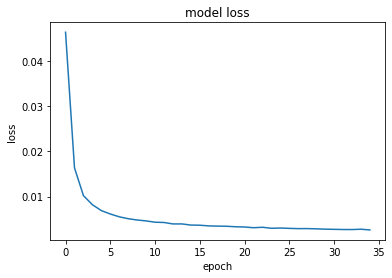

In [ ]:
#@title Draw Loss Graph

with open(paths.history, newline='') as csvfile:
    data = list(csv.reader(csvfile))
loss = np.array([float(data[i][1]) for i in range (1, len(data))])
epochs = np.array([int(data[i][0]) for i in range (1, len(data))])

plt.plot(epochs, loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(paths.loss.format(max(epochs)+1))
plt.show()

# **Load Model :**

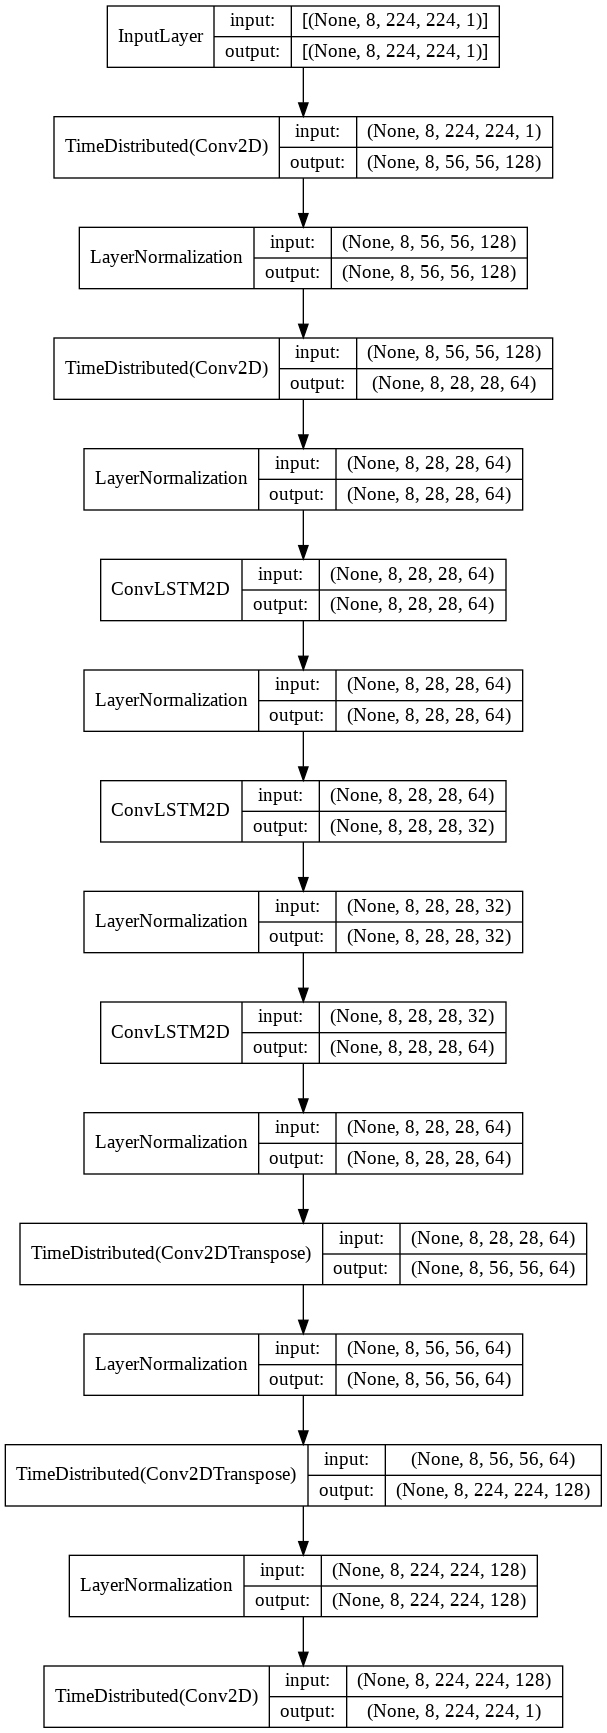

In [ ]:
#@title Load Model
model = load_model(paths.model,custom_objects={'LayerNormalization': LayerNormalization})
plot_model(model, to_file=paths.plot, show_shapes=True, show_layer_names=False, rankdir="VR")

In [ ]:
#@title Display of the architecture
!pip install keras_sequential_ascii
from keras_sequential_ascii import keras2ascii
display.clear_output()
keras2ascii(model)

## **Get Single Test :**

In [ ]:
#@title Define a function that import frames of a single test video   
def get_single_test(test_number):
  test_path = paths.test+"/Test"+test_number
  sz = len([name for name in os.listdir(test_path) if (os.path.isfile(os.path.join(test_path, name)) and (name[-3:]=="tif"))])
  test = np.zeros(shape=(sz, 224, 224, 1))
  cnt = 0
  for f in sorted(listdir(test_path)):
    if str(join(test_path, f))[-3:] == "tif":
      img = Image.open(join(test_path, f)).resize((224, 224))
      img = np.array(img, dtype=np.float32) / 256.0
      test[cnt, :, :, 0] = img
      cnt = cnt + 1
  result = paths.result+"/Test{0:3}/".format(test_number)
  video = paths.video+"/Test{0:3}/".format(test_number)
  create_delete_folder(result, "Create")
  create_delete_folder(video, "Create")
  return test

## **Get Model Output :**

In [ ]:
#@title Define a function that get model output
 
def get_model_output (num):
  #model = get_model()
  model = load_model(paths.model,custom_objects={'LayerNormalization': LayerNormalization})
  print("got model")
  test = get_single_test(num)
  print("got test")
  sz = test.shape[0] - 8
  print("This video contain {} frames".format(sz))
  sequences = np.zeros((sz, 8, 224, 224, 1))
  # apply the sliding window technique to get the sequences
  for i in range(0, sz):
    clip = np.zeros((8, 224, 224, 1))
    for j in range(0, 8):
      clip[j] = test[i + j, :, :, :]
    sequences[i] = clip

  # get the reconstruction cost of all the sequences
  reconstructed_sequences = model.predict(sequences,batch_size=4)
  sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
  
  return sequences, reconstructed_sequences, sz

## **Get test video :**

In [ ]:
#@title Numero of test video  { display-mode: "form" }
num =  4#@param {type:"integer"}

sequences, reconstructed, sz = get_model_output("{0:03}".format(num))
error = sequences-reconstructed

got model
got test
This video contain 172 frames


In [ ]:
#@title View video test

image_folder = paths.test+'/Test{0:03}'.format(num)
video_avi = paths.video+'/Test{0:03}/Test.avi'.format(num)

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".tiff")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_avi, 0, paths.fps, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

video_mp4 = paths.video+'/Test{0:03}/Test.mp4'.format(num)
!ffmpeg -y -i $video_avi $video_mp4
display.clear_output()
url = upload_public(video_mp4)
# then display it
HTML(f"""<video src={url} width=500 controls/>""")

## **Draw Regularity Graph :**

In [ ]:
#@title Define function that draw regularity graph

def threshold_plot(x, y, threshv, color, overcolor):
  mask = ma.masked_less(y, threshv)
  plt.plot(x, y, color, linewidth=3)
  plt.plot(x, mask, overcolor, linewidth=3.2)
  plt.title('Regularity graph - Test{0:03}'.format(num))
  plt.ylabel('Regularity Score Sr(t)')
  plt.xlabel('Frame t')
  red_patch = mpatches.Patch(color='red', label='Anomaly')
  blue_patch = mpatches.Patch(color='blue', label='Regular')
  plt.legend(handles=[red_patch, blue_patch])
  plt.savefig(paths.regularity.format(num))
  plt.show()

def anomaly_detection(sequences, reconstructed, threshv):
  sz = sequences.shape[0]
  sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,sz)])
  sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
  sr = 1.0 - sa
  x = np.arange(len(sr))
  threshold_plot(x, sr, threshv, 'red', 'blue')

In [ ]:
#@title Select temporal threshold
threshold = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}

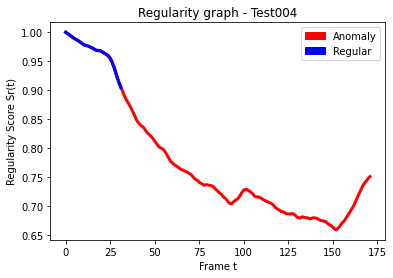

In [ ]:
#@title Draw Regularity Graph
anomaly_detection(sequences, reconstructed, threshold)

In [ ]:
#@title Calculation of the AUC - UCSD

auc_list = [0]*12
with open('/content/drive/Shareddrives/Others/Internship/AUC/ped2.csv', 'w') as f:
  writer = csv.writer(f)
  for num in range (1, 13):
    sequences, reconstructed, sz = get_model_output("{0:03}".format(num))
    error = sequences-reconstructed
    sz = sequences.shape[0]
    nb_frames = sz + 8
    ground_truth=[0]*nb_frames
    for i in range (nb_frames):
      try :
        im = imageio.imread(paths.test+"/Test{0:03}_gt/{1:03}.bmp".format(num, i+1))
      except FileNotFoundError:
        im = imageio.imread(paths.test+"/Test{0:03}_gt/frame{1:03}.bmp".format(num, i+1))
      if (im.max() == 255):
        ground_truth[i-1] = 1
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,nb_frames-8)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    y_pred = [0]*sz
    for i in range (sz):
      if (sr[i] < threshold):
        y_pred[i] = 1
    y = ground_truth[:-8]
    try:
      auc = roc_auc_score(y, y_pred)
    except ValueError:
      auc = 0
      pass
    display.clear_output()
    print("AUC of video (N°", num, ") = ",auc)
    auc_list[num-1] = auc
    data = [num, auc]
    writer.writerow(data)

lst = [x for x in auc_list if x>0]
print("The mean of AUC : ", sum(lst) / len(lst))

In [ ]:
#@title Calculation of the AUC - Avenue

auc_list = [0]*21
with open('/content/drive/Shareddrives/Others/Internship/AUC/avenue.csv', 'w') as f:
  writer = csv.writer(f)
  for num in range (1, 22):
    sequences, reconstructed, sz = get_model_output("{0:03}".format(num))
    error = sequences-reconstructed
    sz = sequences.shape[0]
    nb_frames = sz + 8
    ground_truth=[0]*nb_frames
    mat = scipy.io.loadmat('/content/drive/Shareddrives/Others/Internship/Datasets/Avenue Dataset/testing_label_mask/{}_label.mat'.format(num))
    for i in range (nb_frames):
      im = mat['volLabel'][0][i*2]
      if (im.max() == 1):
        ground_truth[i-1] = 1
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,nb_frames-8)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    y_pred = [0]*sz
    for i in range (sz):
      if (sr[i] < threshold):
        y_pred[i] = 1
    y = ground_truth[:-8]
    try:
      auc = roc_auc_score(y, y_pred)
    except ValueError:
      auc = 0
      pass
    display.clear_output()
    print("AUC of video (N°", num, ") = ",auc)
    auc_list[num-1] = auc
    data = [num, auc]
    writer.writerow(data)

lst = [x for x in auc_list if x>0]
print("The mean of AUC : ", sum(lst) / len(lst))

In [ ]:
#@title Animated regularity graph

x_data = []
y_data = []

fig, ax = plt.subplots()
ax.set_xlim(0, sz-8)
ax.set_ylim(sr.min()-0.02, 1.02)
line, = ax.plot(0, 0)

def animation_frame(i):
    x_data.append(i)
    y_data.append(sr[i])
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    return line, 

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, sz-8), interval=17, blit=True)

# setting up wrtiers object
Writer = writers['ffmpeg']
writer = Writer(fps=paths.fps, metadata={'artist': 'Me'}, bitrate=1800)
animation.save(paths.video+'/Test{0:03}/Graph.avi'.format(num), writer)
plt.close()

video_avi = paths.video+'/Test{0:03}/Graph.avi'.format(num)
video_mp4 = paths.video+'/Test{0:03}/Graph.mp4'.format(num)
!ffmpeg -y -i $video_avi $video_mp4
display.clear_output()
url = upload_public(video_mp4)
# then display it
HTML(f"""<video src={url} width=500 controls/>""")

## **Filtre :**

In [ ]:
#@title Define a function that apply a convolution filtre :

def filtre (num, error):
  sz = error.shape[0]
  filter = np.ones((num,num))
  nb_img = error.shape[0] + 8
  size_img = error.shape[2]
  fil = np.zeros((sz,size_img-num,size_img-num))
  print()
  for t in range (nb_img-8):
    img = error[t][0]
    img = np.asarray(img.reshape(224,224))
    for i in range(size_img-num):
      for j in range(size_img-num):
        fil[t][i][j] = np.square(img[i:i+num, j:j+num]).sum()
  for t in range (1,9):
    img = error[-1][-t]
    img = np.asarray(img.reshape(224,224))
    for i in range(size_img-num):
      for j in range(size_img-num):
        fil[sz-9+t][i][j] = np.square(img[i:i+num, j:j+num]).sum()
  return fil

## **Anomaly Localization :**

In [ ]:
#@title Define a function that draw rectangles in anomaly position

def localization (error, num, img, fil):
  path = paths.result+"/Test{0:03}/".format(num)
  img_path = path + img + ".jpg"
  path = paths.test+'/Test{0:03}/{1}.tif'.format(num, img)
  img = cv2.imread(path)
  image = cv2.resize(img,(224, 224))
  I=[]
  J=[]
  for i in range(208):
    for j in range(208):
      if (fil[j][i]) :
        I.append(i)
        J.append(j)
  overlay = image.copy()
  for i in range (len(I)):
    start_point = (I[i], J[i])
    end_point = (I[i]+16, J[i]+16)
    # thickness = 1
    # color = (0, 0, 255)
    # image = cv2.rectangle(image, start_point, end_point, color, thickness, cv2.FILLED)

    # First we crop the sub-rect from the image
    cv2.rectangle(overlay, start_point, end_point, (0, 0, 200), -1)  # A filled rectangle
    alpha = 0.4  # Transparency factor.

    # Following line overlays transparent rectangle over the image
  image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
  print(img_path)
  cv2.imwrite(img_path, image)

In [ ]:
#@title Anomaly Localization
#@markdown Select spatial threshold after which it will be detected as anomaly
s_threshold = 8 #@param {type:"slider", min:0, max:20, step:0.5}

path = paths.result+"/Test{0:03}/".format(num)
create_delete_folder (path, "Create")

sz = sequences.shape[0]
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed[i])) for i in range(0,sz)])
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa
fil = filtre(16, error)
position = fil > s_threshold
for f in sorted(listdir(paths.test+"/Test{0:03}/".format(num))):
  if f[-3:] == "tif":
    if (int(f[0:3])<sz-8) and (sr[int(f[0:3])-1]<threshold):
      localization (error, num, f[0:3], position[int(f[0:3])-1])
    else : 
      path = paths.result+"/Test{0:03}/".format(num)
      print(path)
      img_path = path + f[0:3] + ".jpg"
      path = paths.test+'/Test{0:03}/{1}.tif'.format(num, f[0:3])
      img = cv2.imread(path)
      image = cv2.resize(img,(224, 224))
      cv2.imwrite(img_path, image)
print("Anomaly localization is done successfully")

In [ ]:
#@title View anomaly localization video

video_avi = paths.video+'/Test{0:03}/Local.avi'.format(num)
path = paths.result+"/Test{0:03}/".format(num)
images = [img for img in sorted(os.listdir(path)) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(path, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_avi, 0, paths.fps, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(path, image)))

cv2.destroyAllWindows()
video.release()

video_mp4 = paths.video+'/Test{0:03}/Local.mp4'.format(num)
!ffmpeg -y -i $video_avi $video_mp4
display.clear_output()
url = upload_public(video_mp4)
# then display it
HTML(f"""<video src={url} width=400 height=300 controls/>""")